In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice
import scipy.sparse as sps
from scipy.sparse import diags
from functools import lru_cache
import pandas as pd

In [25]:
comb_cache = {}
comb_n_cache = {}
comb_n_M_minus_n_cache = {}

def compute_M_OOK(n_OOK):
  M_OOK = n_OOK * 2
  return M_OOK

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination_OOK(n_OOK, M_OOK):
#     M_OOK = n_OOK * 2
#     return math.factorial((M_OOK)) // (math.factorial((M_OOK - n_OOK)) * math.factorial((n_OOK)))

def combination_OOK(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_OOK(n_OOK, P_l, l):
    return combination_OOK(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

def Add_Distribute_OOK(n_OOK, M_OOK, P_a, a):
    return combination_OOK(M_OOK - n_OOK, a) * (P_a)**a * (1 - P_a)**(M_OOK - n_OOK - a)

# define a separate function for computing the probability of error
def P_err_OOK(n_OOK, M_OOK, P_l, P_a,l,a):
  return Loss_Distribute_OOK(n_OOK,P_l,l) * Add_Distribute_OOK(n_OOK, M_OOK, P_a, a)

def P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a):
  return P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=0) 

def P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a,l,a):
  P0 = P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a)
  P1 = P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=1)  + P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=1, a=0) 
  return P0 + P1

def P_D_OOK(n_OOK,M_OOK, P_l,P_a, l=0,a=0):
  return 1 - P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a, l, a)

def P_AB_OOK_diagonal(n_OOK, P_D_OOK) :
    M_OOK = n_OOK * 2
    diag_data = ( 1 / (2**M_OOK) ) # * (P_D_OOK ** n_OOK)  #    #  1/ (2**n_OOK) # probability
    return diag_data

# sum over the elements in rows in the probability matrix P_AB
def P_A_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for row in P_AB_OOK_diagonal]
    else:
        return [sum(row) for row in P_AB_OOK_diagonal] 
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for col in zip(*P_AB_OOK_diagonal)]
    else:
        return [sum(col) for col in zip(*P_AB_OOK_diagonal)]

def H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK):
    P_AB_OOK_diagonal = np.where(P_AB_OOK_diagonal == 0, 1e-9, P_AB_OOK_diagonal)  # replace zero values with 1e-9
    H_OOK = - (P_AB_OOK_diagonal * np.log2(P_AB_OOK_diagonal)).sum() # 2**n_OOK *
    return H_OOK

def I_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK, P_D_OOK):
    M_OOK = n_OOK * 2
    H_AB_OOK_diag = H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK)
    I_AB =  (2**M_OOK) * H_AB_OOK_diag *(1-P_D_OOK) 
    return I_AB

In [26]:
I_AB_OOK_list_0 = []
I_AB_OOK_list_0_1 = []

IperPhoton_AB_OOK_list_0 = []
IperTimeBin_AB_OOK_list_0 = []
IperPhotonTimeBin_AB_OOK_list_0 = []

IperPhoton_AB_OOK_list_0_1 = []
IperTimeBin_AB_OOK_list_0_1 = []
IperPhotonTimeBin_AB_OOK_list_0_1 = []

TimeBin_OOK_list_0 = []
TimeBin_OOK_list_0_1 = []

# for n_OOK in range(3,167):
n_OOK = 1
P = 0
M_OOK = compute_M_OOK(n_OOK)
TimeBin_OOK_list_0.append(M_OOK)
P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
I_AB_OOK_list_0.append(I_AB_OOK_val)

IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
IperPhoton_AB_OOK_list_0.append(IperPhoton_AB_OOK_val)

IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
IperTimeBin_AB_OOK_list_0.append(IperTimeBin_AB_OOK_val)

IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
IperPhotonTimeBin_AB_OOK_list_0.append(IperPhotonTimeBin_AB_OOK_val)

# for n_OOK in range(3, 167):
n_OOK =  1
P = 0.1
M_OOK = compute_M_OOK(n_OOK)
TimeBin_OOK_list_0_1.append(M_OOK)
P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
I_AB_OOK_list_0_1.append(I_AB_OOK_val)

IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
IperPhoton_AB_OOK_list_0_1.append(IperPhoton_AB_OOK_val)

IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
IperTimeBin_AB_OOK_list_0_1.append(IperTimeBin_AB_OOK_val)

IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
IperPhotonTimeBin_AB_OOK_list_0_1.append(IperPhotonTimeBin_AB_OOK_val)

In [27]:
print(TimeBin_OOK_list_0), print(TimeBin_OOK_list_0[-1])

[2]
2


(None, None)

In [28]:
print(TimeBin_OOK_list_0_1), print(TimeBin_OOK_list_0[-1])

[2]
2


(None, None)

Text(2, 2.0, '2.0')

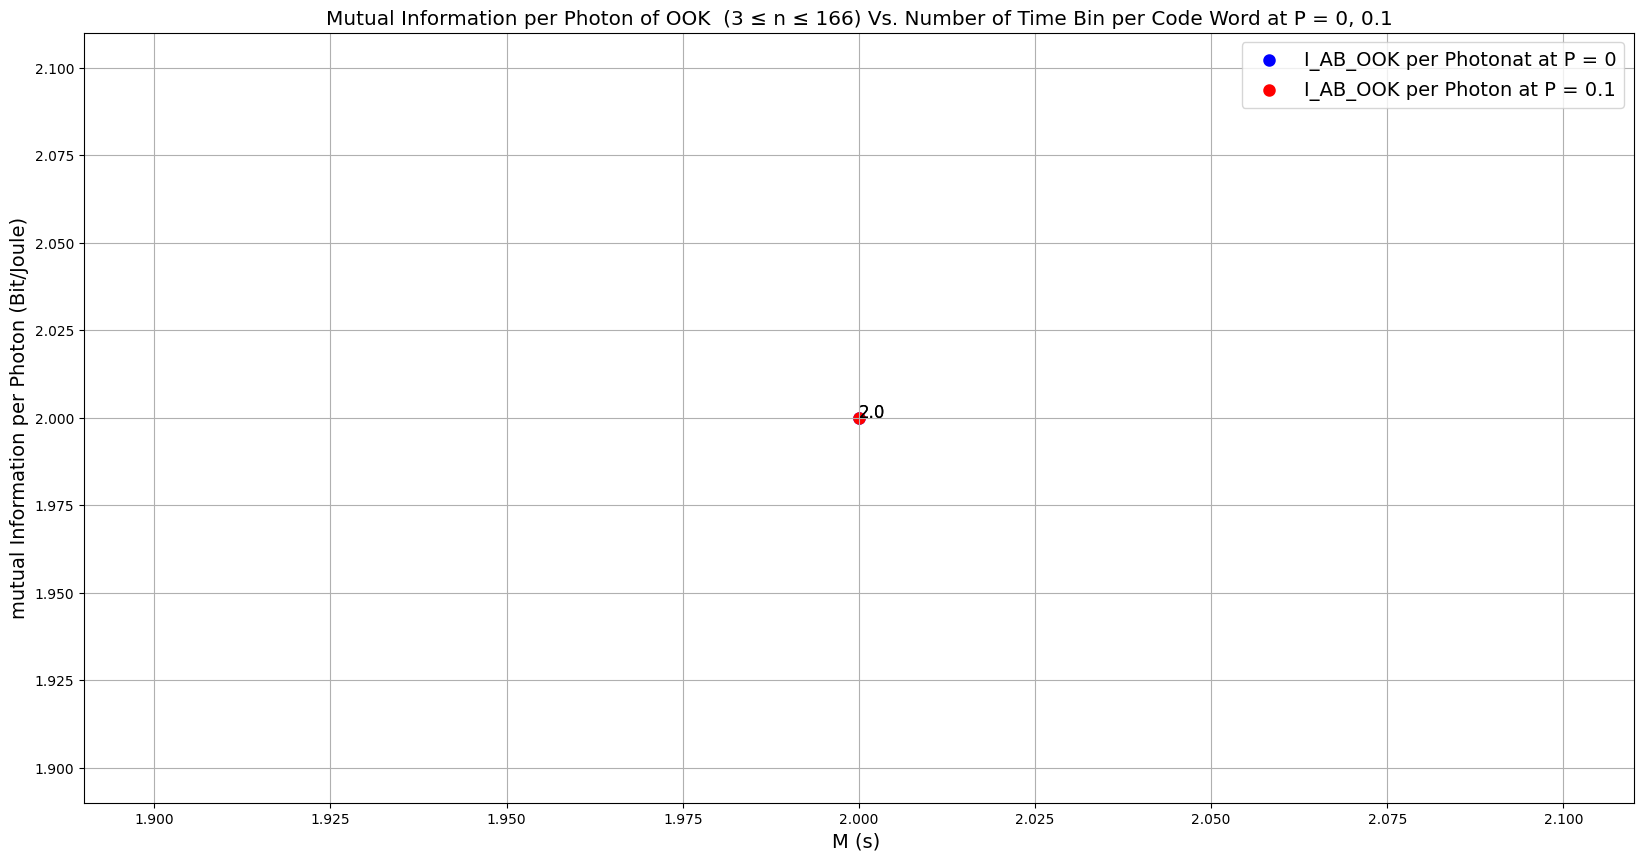

In [29]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of OOK  (3 \u2264 n \u2264 166) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

plt.text(TimeBin_OOK_list_0[0], IperPhoton_AB_OOK_list_0[0], IperPhoton_AB_OOK_list_0[0], size=12)
plt.text(TimeBin_OOK_list_0_1[0], IperPhoton_AB_OOK_list_0_1[0], IperPhoton_AB_OOK_list_0_1[0], size=12)
#for index in range(0,21): # len(TimeBin_OOK_list_0)
# plt.text(TimeBin_OOK_list_0[index], IperPhoton_AB_OOK_list_0[index], round(IperPhoton_AB_OOK_list_0[index],1), size=12)

# for index in range(0,21): # (len(TimeBin_OOK_list_0_1)
# plt.text(TimeBin_OOK_list_0_1[index], IperPhoton_AB_OOK_list_0_1[index], round(IperPhoton_AB_OOK_list_0_1[index],1), size=12)

Transition Probability in Markov Chain  

In [32]:
# transitions = ['A', 'B', 'B', 'C', 'B', 'A', 'D', 'D', 'A', 'B', 'A', 'D']
transitions = ['00', '01', '10', '11']
def rank(c):
    return ord(c) - ord('A')

T = [rank(c) for c in transitions]

#create matrix of zeros

M = [[0]*4 for _ in range(4)]

for (i,j) in zip(T,T[1:]):
    M[i][j] += 1

#now convert to probabilities:
for row in M:
    n = sum(row)
    if n > 0:
        row[:] = [f/sum(row) for f in row]

#print M:

for row in M:
    print(row)

TypeError: ord() expected a character, but string of length 2 found

The transition probabilities for the given list of states. The transition_matrix function takes a list of states as input and returns a transition matrix where each elements M[i][j] represents the prbabiliy of transitioning from state i to state j. 

In [38]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

states = [0,1,2,3]

m = transition_matrix(states)

for row in m: 
    print(''.join('{0:2f}'.format(x) for x in row))

0.0000001.0000000.0000000.000000
0.0000000.0000001.0000000.000000
0.0000000.0000000.0000001.000000
0.0000000.0000000.0000000.000000


In [53]:
# Conditional probability matrix [P(Y|X)]
cond_prob_matrix = np.array([[0.81, 0.09, 0.09, 0.01],
                             [0.09, 0.81, 0.01, 0.09],
                             [0.09, 0.01, 0.81, 0.09],
                             [0.01, 0.09, 0.09, 0.81]])


# calculate the joint probabilitty matrix [P(X,Y)]
joint_prob_matrix = (1/4) * cond_prob_matrix

# calcualte conditional entropy H(Y|X)
conditional_entropy = -np.sum(joint_prob_matrix *np.log2(joint_prob_matrix + 1e-10)) / np.log2(2)

# calcualte marginal entropy H(X)
marginal_entropy = 1

# Calculate the mutual information I(X;Y)
mutual_info = marginal_entropy - conditional_entropy
 
# 2 - 0.938 = 1.062


# Calculate the mutual information per photon
mutual_info_per_photon = mutual_info / (2/2)  # Assuming M = 2

# Print the results
print('Conditional Entropy (H(Y|X)): ', conditional_entropy)
print('Mutual Information (I(X;Y)): ', mutual_info)
print('Mutual Information per Photon: ', mutual_info_per_photon)

# # Marginal probabilities P(X) and P(Y)
# prob_x = np.array([1/4, 1/4, 1/4, 1/4])
# prob_y = np.array([1/4, 1/4, 1/4, 1/4])

# # Calculate the mutual information
# mutual_info = 0
# for i in range(4):
#     for j in range(4):
#         p_xy = cond_prob_matrix[i][j] * prob_x[i] * prob_y[j]
#         if p_xy > 0:
#             mutual_info += -p_xy * np.log2(p_xy / (prob_x[i] * prob_y[j]))

# # Print the mutual information
# print('Mutual Information: ', mutual_info)


Conditional Entropy (H(Y|X)):  2.9379911848702505
Mutual Information (I(X;Y)):  -1.9379911848702505
Mutual Information per Photon:  -1.9379911848702505


In [50]:
conditional_entropy

4.2386253125878

In [46]:
# Conditional probability matrix [P(Y|X)]
cond_prob_matrix = np.array([[0.9, 0.1],
                             [0.1, 0.9]])

# Marginal probabilities P(X) and P(Y)
prob_x = np.array([1/4, 1/4])
prob_y = np.array([1/4, 1/4])

# Calculate the mutual information
mutual_info = 0
for i in range(2):
    for j in range(2):
        p_xy = cond_prob_matrix[i][j] * prob_x[i] * prob_y[j]
        if p_xy > 0:
            mutual_info += -p_xy * np.log2(p_xy / (prob_x[i] * prob_y[j]))

# Print the mutual information
print('Mutual Information: ', mutual_info)

Mutual Information:  0.058624449198660146


In [47]:
#the following code takes a list such as
#[1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
#with states labeled as successive integers starting with 0
#and returns a transition matrix, M,
#where M[i][j] is the probability of transitioning from i to j

def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:

t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
m = transition_matrix(t)
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

0.67 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.50 0.12 0.12 0.25 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00
0.00 0.00 0.00 0.50 0.50 0.00 0.00 0.00 0.00
0.00 0.20 0.00 0.00 0.20 0.60 0.00 0.00 0.00
0.17 0.17 0.00 0.00 0.17 0.33 0.00 0.17 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.33 0.00 0.00 0.00 0.33 0.00 0.00 0.33
